In [1]:
import os, re, glob
import numpy as np
import xarray as xr
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from scipy.stats import kendalltau

import geopandas as gpd
from matplotlib.gridspec import GridSpec

# ======== paths (AJUSTE AQUI se necessário) ========
NDVI_TIF_DIR = "/mnt/9678CCD778CCB771/ndvi"        # pasta com os .tif (duas imagens por mês)
CHIRPS_NC    = "dataset/netcdf_data/chirps_mensal_1981_2023.nc"   # já existente
NDVI_NC_OUT  = "dataset/netcdf_data/ndvi_mensal.nc"
SHAPE_ESTADOS = "dataset/shape/caatinga_estados.shp"

# (opcionais para salvar resultados)
NDVI_FEATURES_NC = "dataset/netcdf_data/ndvi_features.nc"
NDVI_CLUSTERS_NC = "dataset/netcdf_data/ndvi_clusters.nc"


In [ ]:
'''
# NÃO É NECESSÁRIO RODAR, O DADO NDVI.NC JÁ ESTÁ PRONTO
# (mas pode ser útil para entender o processo de construção do NDVI mensal)
# ==================================================

# --- 0) grade-alvo a partir do CHIRPS ---
precip = xr.open_dataarray(CHIRPS_NC)   # dims: time, lat, lon
# garantir lat crescente para construir transform
if precip.lat.values[0] > precip.lat.values[-1]:
    precip = precip.sortby("lat")
if precip.lon.values[0] > precip.lon.values[-1]:
    precip = precip.sortby("lon")

lat = precip.lat.values
lon = precip.lon.values
dy = float(np.diff(lat).mean())
dx = float(np.diff(lon).mean())
height = lat.size
width  = lon.size

# upper-left (canto superior esquerdo) com coordenada de borda
north = lat.max() + dy/2.0
west  = lon.min() - dx/2.0
dst_transform = from_origin(west, north, dx, dy)
dst_crs = "EPSG:4326"

# --- 1) agrupar TIFFs por (ano, mês) ---
def parse_year_month(fname):
    m = re.search(r'(\d{4})[^\d]?(\d{1,2})', os.path.basename(fname))
    if not m:
        raise ValueError(f"Não consegui extrair ano/mês de: {fname}")
    return int(m.group(1)), int(m.group(2))

files = sorted(glob.glob(os.path.join(NDVI_TIF_DIR, "*.tif")))
groups = {}
for f in files:
    y, mo = parse_year_month(f)
    groups.setdefault((y, mo), []).append(f)

# --- 2) média mensal por (ano, mês) no CRS nativo ---
mensais_native = []
times = []

for (y, mo), flist in sorted(groups.items()):
    arrays = []
    ref_profile = None
    for p in flist:
        with rasterio.open(p) as src:
            arr = src.read(1)  # float32; nodata já vem como NaN se existir
            # NUNCA mascare -2000: é NDVI válido (-0.2)
            arrays.append(arr)
            if ref_profile is None:
                ref_profile = src.profile.copy()  # CRS/transform/shape de referência

    # média das cenas (ignora NaN)
    stack = np.dstack(arrays)
    month_native = np.nanmean(stack, axis=2)  # float32

    mensais_native.append( (month_native, ref_profile) )
    times.append(np.datetime64(f"{y:04d}-{mo:02d}-01"))

# --- 3) reprojetar cada mensal para a grade do CHIRPS + aplicar escala 1e-4 ---
mensais_reproj = []
for (month_native, src_profile) in mensais_native:
    dst = np.full((height, width), np.nan, dtype="float32")

    reproject(
        source=month_native,
        destination=dst,
        src_transform=src_profile["transform"],
        src_crs=src_profile["crs"],
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
        src_nodata=np.nan,
        dst_nodata=np.nan,
    )

    # aplicar escala de NDVI (valores vieram ~0..10000, às vezes negativos)
    dst_scaled = dst / 10000.0  # agora em [-1, 1]
    mensais_reproj.append(dst_scaled)

# --- 4) empacotar em xarray e salvar ---
ndvi = xr.DataArray(
    np.stack(mensais_reproj, axis=0),  # time, lat, lon
    dims=("time","lat","lon"),
    coords={"time": ("time", times), "lat": ("lat", lat), "lon": ("lon", lon)},
    name="ndvi"
)
ndvi.attrs.update(units="1", long_name="NDVI (mensal, média de 2 cenas, reprojetado p/ CHIRPS)")
ndvi = ndvi.sortby("time")

ndvi.to_netcdf(NDVI_NC_OUT)
print("NDVI mensal salvo em:", NDVI_NC_OUT, ndvi.shape, ndvi.dtype)
'''

In [2]:
ndvi = xr.open_dataarray(NDVI_NC_OUT)  # reabrir para garantir limpeza de memória
# Climatologia sazonal (forma robusta)
ndvi_seasonal_mean = ndvi.groupby("time.season").mean("time")  # dims: season, lat, lon

season_DJF = ndvi_seasonal_mean.sel(season="DJF").reset_coords("season", drop=True)
season_MAM = ndvi_seasonal_mean.sel(season="MAM").reset_coords("season", drop=True)
season_JJA = ndvi_seasonal_mean.sel(season="JJA").reset_coords("season", drop=True)
season_SON = ndvi_seasonal_mean.sel(season="SON").reset_coords("season", drop=True)

# 3.1 — média anual (média no tempo)
longterm_mean = ndvi.mean("time")

# 3.2 — média sazonal (DJF/MAM/JJA/SON) corretamente:
# criar rótulo de estação
season_map = {12:"DJF", 1:"DJF", 2:"DJF",
              3:"MAM", 4:"MAM", 5:"MAM",
              6:"JJA", 7:"JJA", 8:"JJA",
              9:"SON",10:"SON",11:"SON"}
seasons = xr.DataArray([season_map[m] for m in ndvi["time.month"].values], dims=["time"],
    name="season")

# 3.3 — tendências (slope linear e Kendall tau) por pixel
def slope_linear(y, t):
    # regressão linear simples y ~ a*t + b; retorna 'a'
    mask = np.isfinite(y)
    if mask.sum() < 3:
        return np.nan
    a, b = np.polyfit(t[mask], y[mask], 1)
    return a

def kendall_tau(y, t):
    mask = np.isfinite(y)
    if mask.sum() < 3:
        return np.nan
    tau, p = kendalltau(t[mask], y[mask])
    return tau

t_index = np.arange(ndvi.sizes["time"])  # 0..N-1
slope_da = xr.apply_ufunc(
    slope_linear, ndvi, xr.DataArray(t_index, dims=["time"]),
    input_core_dims=[["time"], ["time"]],
    vectorize=True, dask="parallelized", output_dtypes=[float]
)

tau_da = xr.apply_ufunc(
    kendall_tau, ndvi, xr.DataArray(t_index, dims=["time"]),
    input_core_dims=[["time"], ["time"]],
    vectorize=True, dask="parallelized", output_dtypes=[float]
)

# empacotar features em um Dataset
features_ndvi = xr.Dataset({
    "annual_mean": longterm_mean,
    "season_DJF":  season_DJF,
    "season_MAM":  season_MAM,
    "season_JJA":  season_JJA,
    "season_SON":  season_SON,
    "slope":       slope_da,
    "kendall_tau": tau_da
})
features_ndvi.to_netcdf(NDVI_FEATURES_NC)


In [3]:
# montar matriz de features (flatten)
feat_stack = xr.concat([
    features_ndvi["annual_mean"],
    features_ndvi["season_DJF"],
    features_ndvi["season_MAM"],
    features_ndvi["season_JJA"],
    features_ndvi["season_SON"],
    features_ndvi["slope"],
    features_ndvi["kendall_tau"]
], dim="feat").transpose("lat","lon","feat")

arr = feat_stack.values   # (lat, lon, feat)
mask_valid = np.all(np.isfinite(arr), axis=2)  # válido se todas as features são válidas

X = arr[mask_valid]  # (n_pix, n_feat)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)


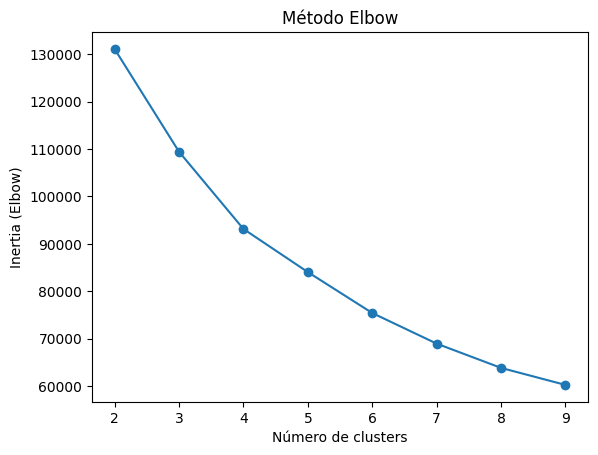

In [4]:
inertias = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(Xz)
    inertias.append(km.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel("Número de clusters")
plt.ylabel("Inertia (Elbow)")
plt.title("Método Elbow")
plt.show()

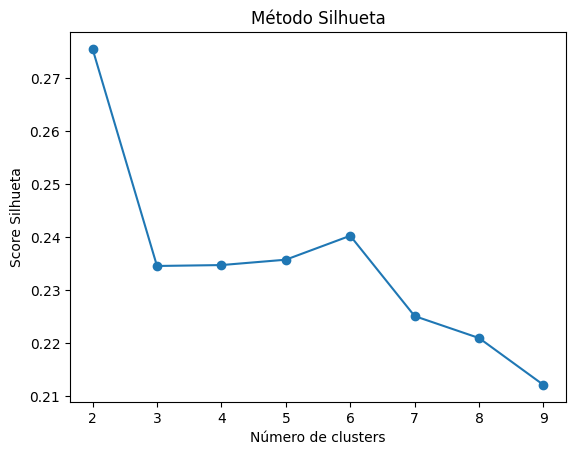

In [5]:
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(Xz)
    sil = silhouette_score(Xz, km.labels_)
    sil_scores.append(sil)

plt.plot(K, sil_scores, 'o-')
plt.xlabel("Número de clusters")
plt.ylabel("Score Silhueta")
plt.title("Método Silhueta")
plt.show()


In [6]:

# número de clusters 
n_clusters = 6
ward = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
labels_valid = ward.fit_predict(Xz)  # 0..k-1

# reconstruir mapa (1..k)
labels_ndvi = np.full(mask_valid.shape, np.nan)
labels_ndvi[mask_valid] = labels_valid + 1

labels_ndvi_da = xr.DataArray(labels_ndvi, coords={"lat":features_ndvi.lat, "lon":features_ndvi.lon}, dims=("lat","lon"))
labels_ndvi_da.name = "ndvi_cluster"
labels_ndvi_da.to_netcdf(NDVI_CLUSTERS_NC)



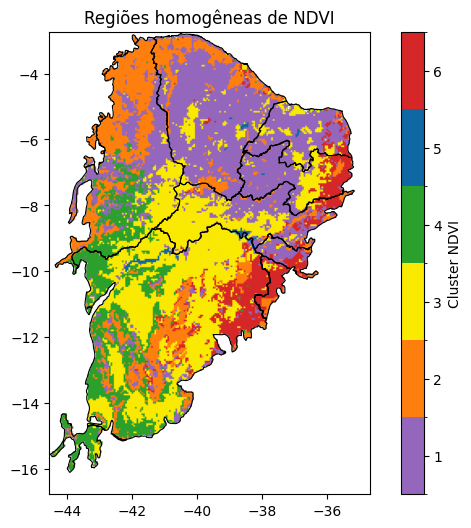

In [7]:
gdf = gpd.read_file(SHAPE_ESTADOS)

cores = ["#9467bd","#ff7f0e","#fae900","#2ca02c","#0f68a3", "#d62728"] #,"#fae900"
cmap_cat = mcolors.ListedColormap(cores[:n_clusters])
bounds = np.arange(0.5, n_clusters+1.5, 1)
norm   = mcolors.BoundaryNorm(bounds, cmap_cat.N)

plt.figure(figsize=(8,6))
plt.imshow(labels_ndvi_da, origin="upper",
           extent=[labels_ndvi_da.lon.min(), labels_ndvi_da.lon.max(),
                   labels_ndvi_da.lat.min(), labels_ndvi_da.lat.max()],
           cmap=cmap_cat, norm=norm)
gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=0.8)
cbar = plt.colorbar(ticks=np.arange(1, n_clusters+1)); cbar.set_label("Cluster NDVI")
plt.title("Regiões homogêneas de NDVI")
plt.savefig("outputs/maps/ndvi_clusters_map.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# --------------------------
# 1) Climatologia mensal do NDVI (média por mês ao longo dos anos)
# --------------------------
clim_mensal_ndvi = ndvi.groupby("time.month").mean("time")  # (month, lat, lon)

# --------------------------
# 2) Médias mensais por cluster
# --------------------------
cluster_map = labels_ndvi_da  # se o seu nome for 'labels_map', troque aqui
clusters_ids = sorted(np.unique(cluster_map.values[~np.isnan(cluster_map.values)]).astype(int))

clim_cluster_mensal = []
for cid in clusters_ids:
    # média espacial no cluster (NaN fora): resulta em série 12x (mês)
    serie = clim_mensal_ndvi.where(cluster_map == cid).mean(dim=("lat","lon"))
    clim_cluster_mensal.append(serie)

clim_cluster_mensal = xr.concat(clim_cluster_mensal, dim="cluster")
clim_cluster_mensal = clim_cluster_mensal.assign_coords(cluster=("cluster", clusters_ids))


In [9]:
# --------------------------
# 3) Paleta categórica para 6 clusters (mesma do mapa)
# --------------------------
cores = ["#9467bd","#ff7f0e","#fae900","#2ca02c","#0f68a3", "#d62728"]  # 6 cores
cmap_categorico = mcolors.ListedColormap(cores[:len(clusters_ids)])
bounds = np.arange(0.5, len(clusters_ids) + 1.5, 1)
norm   = mcolors.BoundaryNorm(bounds, cmap_categorico.N)


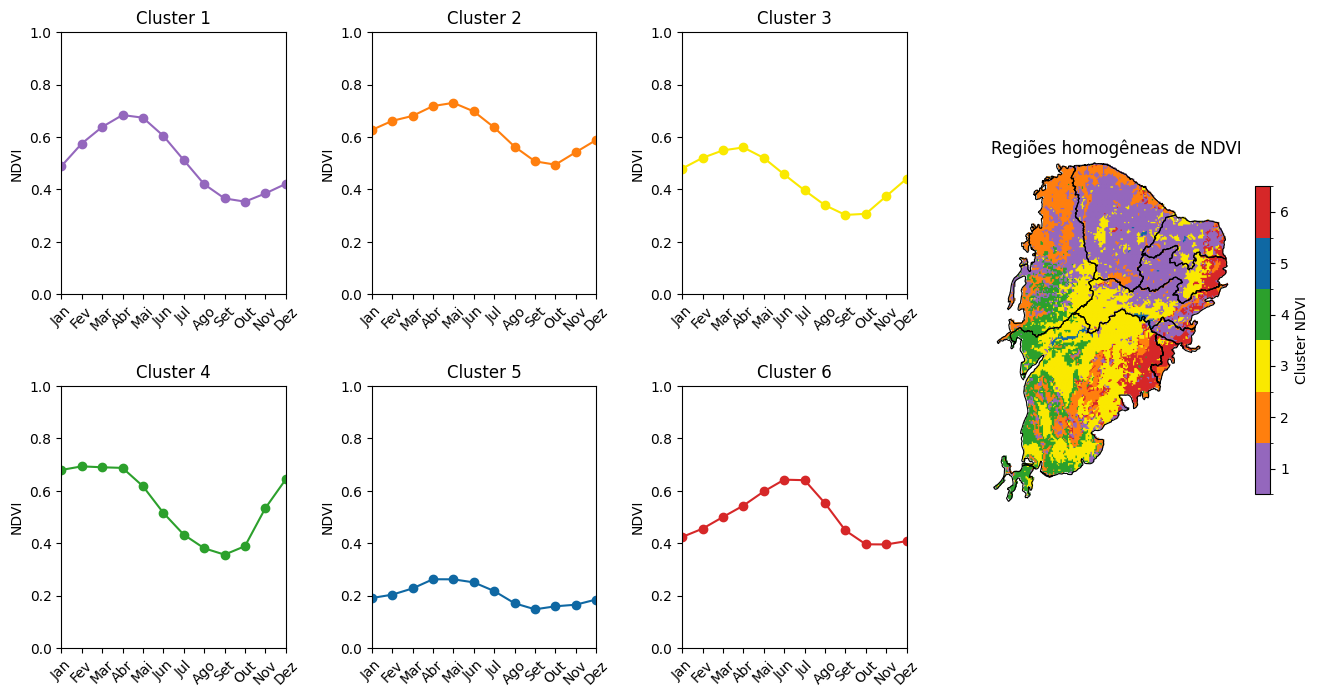

In [11]:
# --------------------------
# 4) Figura estilo Oliveira (2015): 2x4 com o mapa ocupando a última coluna
# --------------------------
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 4, figure=fig, width_ratios=[0.8, 0.8, 0.8, 1.1], wspace=0.35, hspace=0.35)

# 4.1 Seis painéis de climatologia mensal (clusters 1..6)
meses_lbl = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]
for i, cid in enumerate(clusters_ids):
    ax = fig.add_subplot(gs[i // 3, i % 3])  # 3 gráficos por linha
    dados = clim_cluster_mensal.sel(cluster=cid).values  # 12 valores
    ax.plot(range(1, 13), dados, marker='o', color=cores[i])
    ax.set_title(f"Cluster {cid}")
    ax.set_xticks(range(1, 13)); ax.set_xticklabels(meses_lbl, rotation=45)
    ax.set_ylim(0, 1)  # NDVI em [0,1]; ajuste se seu NDVI tiver negativos
    ax.set_xlim(1, 12)
    ax.grid(False) #, ls="--", alpha=0.4
    ax.set_ylabel("NDVI")

# 4.2 Mapa de clusters (coluna inteira à direita)
ax_mapa = fig.add_subplot(gs[:, 3])
im = ax_mapa.imshow(
    cluster_map,
    origin="upper",
    extent=[float(ndvi.lon.min()), float(ndvi.lon.max()),
            float(ndvi.lat.min()), float(ndvi.lat.max())],
    cmap=cmap_categorico, norm=norm
)
ax_mapa.set_title("Regiões homogêneas de NDVI")
#ax_mapa.set_xlabel("Longitude"); ax_mapa.set_ylabel("Latitude")
ax_mapa.axis("off")

# Contorno dos estados
gdf.boundary.plot(ax=ax_mapa, color='black', linewidth=0.8)

# Barra de cores categórica (valores inteiros 1..6)
cbar = plt.colorbar(im, ax=ax_mapa, ticks=np.arange(1, len(clusters_ids)+1), shrink=0.5)
cbar.set_label("Cluster NDVI")

#plt.tight_layout()
plt.savefig("outputs/maps/ndvi_clusters_series.png", dpi=300, bbox_inches='tight')
plt.show()